# import

In [ ]:
from utils import *

NOTEBOOK_ID = '04'
RUN_MODELS = False
RUN_LAZY_REGRESSORS = False
RUN_LAZY_CLASSIFIERS = False

/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


In [3]:
onehot_df = pd.read_pickle(f'{ENCODING_DIR}/01-dataset/hummel_encodings.pkl')
onehot_X = np.asarray([np.array(emb) for emb in onehot_df['onehot_encoding']])
esm_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl')
esm_X = np.asarray([np.array(emb) for emb in esm_df['esm2_t33_650M_UR50D']])
alphabet_X = np.asarray([[AA_TO_I[aa] for aa in x] for x in onehot_df['AAseq']])
esm_mean_X = np.mean(esm_X,axis=-1)
Xs = {'alphabet':alphabet_X, 'esm_mean':esm_mean_X}

y = esm_df['activity'].to_numpy()
thresh = esm_df['activity'].median()
y_cont = y.reshape(-1, 1)
y_cont = preprocessing.MinMaxScaler().fit_transform(y_cont)
y_cont = preprocessing.StandardScaler().fit_transform(y_cont)
y_bin = (y >= thresh).astype(np.int64).reshape(-1, 1)    

In [4]:
if RUN_MODELS:
    y_test_hats = {}
    for key, X in Xs.items():
        print(key)
        train, val, test, idx = get_stratified_split(X,y_bin,y_cont,train_size=0.80,random_state=0,as_tensor=False)
        (X_train, y_bin_train, y_cont_train) = train
        (X_val, y_bin_val, y_cont_val) = val
        (X_test, y_bin_test, y_cont_test) = test
        (train_idx, val_idx, test_idx) = idx

        y_cont_trainval = np.concatenate([y_cont_train, y_cont_val])

        X_trainval = np.concatenate([X_train, X_val])
            
        print('linear regressor')
        model = LinearRegression().fit(X_trainval, y_cont_trainval.flatten())
        y_test_hats[(key, 'linear_regression')] = (model.predict(X_test), y_cont_test)

        print('SVM')
        svr = SVR()
        svr.fit(X_trainval, y_cont_trainval.flatten())
        y_test_hats[(key, 'svm')] = (svr.predict(X_test), y_cont_test)

        print('random forest')
        random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        random_forest_regressor.fit(X_trainval_2d, y_cont_trainval.flatten())
        y_test_hats[(key, 'random_forest')] = (random_forest_regressor.predict(X_test), y_cont_test)

        print('xgboost')
        xg_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
        xg_regressor.fit(X_trainval, y_cont_trainval)
        y_test_hats[(key, 'xgboost')] = (xg_regressor.predict(X_test), y_cont_test)

    tmp_df = pd.DataFrame([y_test_hats]).T
    tmp_df.to_pickle(f'{SIMPLE_ARCHITECTURE_DIR}/linear_model_test.pkl')

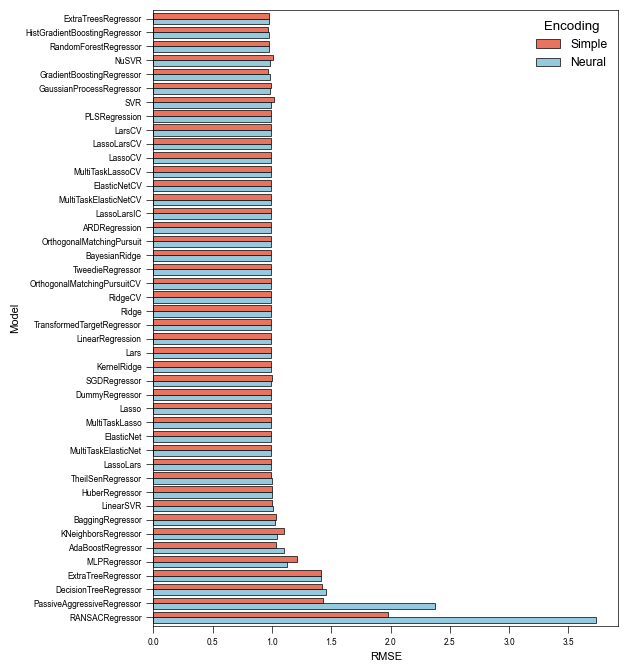

In [ ]:
if RUN_LAZY_REGRESSORS:
    skip_regressors = ['PoissonRegressor','QuantileRegressor']
    regressors = [est for est in all_estimators() if (issubclass(est[1], RegressorMixin) and (est[0] not in skip_regressors))]
    for key, X in Xs.items():
        if not os.path.isfile(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_regressor_{key}.csv'):
            print(key)
            train, val, test, idx = get_stratified_split(X,y_bin,y_cont,train_size=0.80,random_state=0,as_tensor=False)
            (X_train, y_bin_train, y_cont_train) = train
            (X_val, y_bin_val, y_cont_val) = val
            (X_test, y_bin_test, y_cont_test) = test
            (train_idx, val_idx, test_idx) = idx

            X_trainval = np.concatenate([X_train, X_val])
            y_cont_trainval = np.concatenate([y_cont_train, y_cont_val])

            reg = LazyRegressor(verbose=1,predictions=False,regressors=regressors)
            models = reg.fit(X_trainval, X_test, y_cont_trainval, y_cont_test)
            models[0].to_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_regressor_{key}.csv')
else:
    esm_models = pd.read_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_regressor_esm_mean_dedup.csv')
    esm_models['encoding'] = 'Neural'
    alphabet_models = pd.read_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_regressor_alphabet_dedup.csv')
    alphabet_models['encoding'] = 'Simple'
    models = pd.concat([esm_models,alphabet_models]).reset_index(drop=True)

plt.figure(figsize=(6,8))
g = sns.barplot(data=models,y='Model',x='RMSE',hue='encoding',palette=['tomato','skyblue'],hue_order=['Simple','Neural'],edgecolor='black',linewidth=0.5)
g.set(ymargin=0.005)
g.legend(frameon=False,title='Encoding')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-lazy_regressor.png',dpi=400,bbox_inches='tight',transparent=False)

# simple architectures on classification task

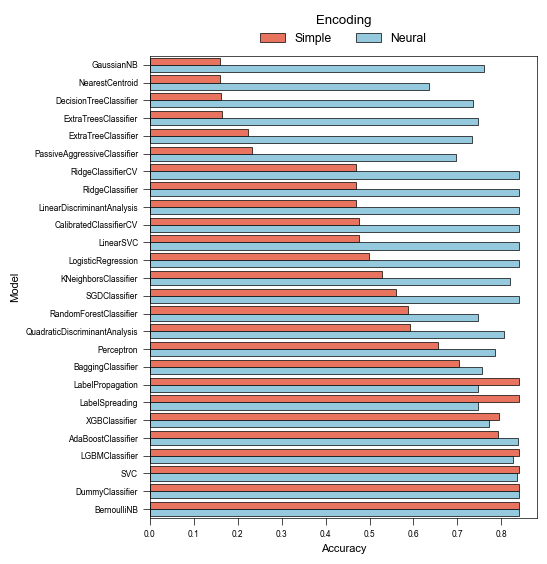

In [ ]:
if RUN_LAZY_CLASSIFIERS:
    for key, X in Xs.items():
        print(key)
        y_bin_morffy = (y >= np.mean(y) + np.std(y)).astype(np.int64).reshape(-1, 1)    
        train, val, test, idx = get_stratified_split(X,y_bin_morffy,y_cont,train_size=0.80,random_state=0,as_tensor=False)
        (X_train, y_bin_train, y_cont_train) = train
        (X_val, y_bin_val, y_cont_val) = val
        (X_test, y_bin_test, y_cont_test) = test
        (train_idx, val_idx, test_idx) = idx

        y_bin_trainval = np.concatenate([y_bin_train, y_bin_val])

        clf = LazyClassifier(verbose=1,predictions=False)
        models = clf.fit(X_trainval, X_test, y_bin_trainval, y_bin_test)
        models[0].to_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_classifier_{key}.csv')
else:
    esm_models = pd.read_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_classifier_esm_mean_dedup.csv')
    esm_models['encoding'] = 'Neural'
    alphabet_models = pd.read_csv(f'{SIMPLE_ARCHITECTURE_DIR}/lazy_classifier_alphabet_dedup.csv')
    alphabet_models['encoding'] = 'Simple'
    models = pd.concat([esm_models,alphabet_models]).reset_index(drop=True)

plt.figure(figsize=(5,6))
g = sns.barplot(data=models.sort_values(['Accuracy']),y='Model',x='Accuracy',hue='encoding',palette=['tomato','skyblue'],hue_order=['Simple','Neural'],edgecolor='black',linewidth=0.5)
g.legend(frameon=False,title='Encoding')
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title='Encoding', frameon=False,
)

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-lazy_classifier.png',dpi=400,bbox_inches='tight',transparent=False)

In [10]:
test_df = pd.read_pickle(f'{SIMPLE_ARCHITECTURE_DIR}/linear_model_test.pkl').rename(columns={0:'results'})
test_df['r'] = test_df['results'].apply(lambda x: pearsonr(x[0],x[1].flatten())[0])
test_df['rmse'] = test_df['results'].apply(lambda x: mean_squared_error(x[0],x[1].flatten(),squared=False)  )
test_df['r2'] = test_df['results'].apply(lambda x: r2_score(x[0],x[1].flatten())  )
test_df = test_df.drop(columns=['results'])
test_df

,r,rmse,r2
"(alphabet, linear_regression)",0.10,1.00,-62.07
"(alphabet, svm)",0.08,1.03,-12.64
"(alphabet, random_forest)",0.18,0.99,-17.09
"(alphabet, xgboost)",0.21,0.98,-16.64


In [ ]:
df = None
for file in glob(f'{SIMPLE_ARCHITECTURE_DIR}/*_lazy_classifier.csv'):
    handle = file.split('/')[-1]
    dataset_name = handle.split('_')[0]
    X_name = handle.split('_')[1]
    tmp_df = pd.read_csv(file)
    tmp_df['dataset'] = dataset_name
    tmp_df['encoding'] = X_name
    df = pd.concat([tmp_df,df]).reset_index(drop=True)
df = df[['Model','Accuracy','F1 Score','dataset','encoding']]

,Model,Accuracy,F1 Score,dataset,encoding
0,NearestCentroid,0.55,0.62,harmonized,alphabet
1,DecisionTreeClassifier,0.74,0.75,harmonized,alphabet
2,ExtraTreeClassifier,0.74,0.75,harmonized,alphabet
3,PassiveAggressiveClassifier,0.74,0.75,harmonized,alphabet
4,LabelSpreading,0.85,0.79,harmonized,alphabet
...,...,...,...,...,...
160,QuadraticDiscriminantAnalysis,0.80,0.82,morffy,onehot
161,GradientBoostingClassifier,0.91,0.87,morffy,onehot
162,LabelPropagation,0.91,0.87,morffy,onehot
163,LabelSpreading,0.91,0.87,morffy,onehot
